In [ ]:
# Import packages and setup gpu configuration.
# This code block shouldnt need to be adjusted!
import os
import sys
import json
import yaml
import numpy as np
import math
import time
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import webdataset as wds
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import utils

from mae_utils import models
from mae_utils.flat import NSDDataset, load_nsd_flat_mask
from mae_utils.flat import HCPDataset, load_hcp_flat_mask
import mae_utils.visualize as vis
from mae_utils.losses import SimCLRHandler
from mae_utils.logging import get_system_metrics

torch.backends.cuda.matmul.allow_tf32 = True # faster than standard float32
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True # fixes Conv3D CUDNN_NOT_SUPPORTED error

from env import FMRI_FM_ROOT

# Set the default config
CONFIG = "config"

### Multi-GPU config ###
device_count = torch.cuda.device_count()
print(f"Number of available CUDA devices: {device_count}")

local_rank = os.getenv('LOCAL_RANK')
local_rank = 0 if local_rank is None else int(local_rank)
print(f"LOCAL RANK={local_rank}")


node = os.getenv('SLURM_NODEID')
node = 0 if node is None else int(node)
print(f"NODE={node}")

global_rank = os.getenv('RANK')
global_rank = 0 if global_rank is None else int(global_rank)
print(f"GLOBAL RANK={global_rank}")

world_size = os.getenv('WORLD_SIZE')
world_size = 1 if world_size is None else int(world_size)
print(f"WORLD_SIZE={world_size}")

distributed = True if world_size>1 else False

if utils.is_interactive():
    # Following allows you to change functions in other files and 
    # have this notebook automatically update with your revisions
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')

# Load parameters from yaml config
print("\n__CONFIG__")
config_name = os.getenv('CONFIG') or CONFIG
config_path = FMRI_FM_ROOT / f"config/{config_name}.yaml"
config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)

# Override with env vars
for attribute_name in config:
    if attribute_name in os.environ:
        attribute_value = os.environ[attribute_name]
        config[attribute_name] = attribute_value

for attribute_name in config.keys():
    if global_rank==0:
        print(f"{attribute_name} = {config[attribute_name]}")
    globals()[attribute_name] = config[f'{attribute_name}']
print("\n")

# setup wandb seed
if wandb_log and (wandb_rand==0):
    wandb_rand = str(np.random.randint(99998)+1)
    print("wandb_rand", wandb_rand)
    model_name = model_name + "_" + str(wandb_rand)

# Create outdir for ckpt and config.yaml
outdir = os.path.join(FMRI_FM_ROOT, f'checkpoints/{model_name}')
print("outdir", outdir)

# Load previous config.yaml if available (so you can resume from it)
if os.path.exists(f"{outdir}/config.yaml"):
    config = yaml.load(open(f"{outdir}/config.yaml", 'r'), Loader=yaml.FullLoader)
    print(f"Loaded config.yaml from ckpt folder {outdir}")

    # create global variables from the config
    print("\n__REPLACING_CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")

data_type = torch.float32 # change depending on your mixed_precision
global_batch_size = batch_size * world_size

# FSDP Setup
if distributed:
    import torch.distributed as dist
    from torch.distributed.fsdp import FullyShardedDataParallel as FSDP
    from torch.distributed.fsdp import MixedPrecision, StateDictType
    from torch.distributed.fsdp.api import CPUOffload, ShardingStrategy
    import functools
    from torch.distributed.fsdp.wrap import size_based_auto_wrap_policy, transformer_auto_wrap_policy
    print(f"setting device to cuda:{local_rank}")
    torch.cuda.set_device(local_rank)
    device = torch.device('cuda',local_rank)
    os.environ['TORCH_NCCL_BLOCKING_WAIT'] = '0'
    dist.init_process_group("nccl", timeout=timedelta(seconds=720000), rank=global_rank, world_size=world_size)
    print(f"\nSuccessfully set cuda:{local_rank} | global_rank{global_rank} | node{node}")
    dist.barrier() 
    print(f"global_rank{global_rank} passed barrier")
else:
    device = torch.device('cuda')

print("PID of this process =",os.getpid())
print("device =", device, "distributed =",distributed, "rank =", global_rank, "local rank =", local_rank, "world size =", world_size, "data_type =", data_type)

# seed all random functions
utils.seed_everything(seed + global_rank)

Number of available CUDA devices: 8
LOCAL RANK=0
NODE=0
GLOBAL RANK=0
WORLD_SIZE=1

__CONFIG__
model_name = HCP_large_pt1
datasets_to_include = HCP
hcp_flat_path = /home/connor/fmri-fm/datasets/HCP-Flat
nsd_flat_path = /home/connor/fmri-fm/datasets/NSD-Flat
model_size = large
global_pool = False
cls_forward = False
gsr = False
use_contrastive_loss = False
use_decoder_contrastive_loss = False
cls_embed = False
decoder_cls_embed = False
use_source_embeds = False
source_embed_mode = add
source_embed_train_mode = ce
patch_size = 16
pct_masks_to_decode = 1
decoder_embed_dim = 512
num_frames = 16
mask_ratio = 0.75
pred_t_dim = 8
t_patch_size = 2
no_qkv_bias = False
sep_pos_embed = True
trunc_init = False
norm_pix_loss = False
contrastive_loss_weight = 1.0
train_split = 0.9
batch_size = 32
same_run_samples = 16
num_workers = 1
num_epochs = 100
seed = 42
base_lr = 0.001
num_samples_per_epoch = 200000
grad_clip = 1.0
grad_accumulation_steps = 1
plotting = True
num_sessions = 40
sub_min = 0
ckpt

## Create dataset and data loaders

In [2]:
num_batches = num_samples_per_epoch // (world_size * batch_size)
print("num_batches", num_batches)
print(f"datasets_to_include {datasets_to_include}")
assert datasets_to_include in {"HCP", "NSD", "BOTH"}, "datasets_to_include must be 'HCP', 'NSD', or 'BOTH'"
assert (batch_size / same_run_samples) == (batch_size // same_run_samples), f"batch_size {batch_size} must be evenly divisible by same_run_samples {same_run_samples}"

if "HCP" in datasets_to_include:
    flat_mask = load_hcp_flat_mask(hcp_flat_path)
    nsd_mask, hcp_mask = None, None
    
    train_dataset = HCPDataset(root=hcp_flat_path,
                                  split="train", # train=19464 (1096 subjects) test=2169 (919 subjects) all=21633
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames*2,
                                  train_split=train_split)
    train_dl = wds.WebLoader(train_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)
    print(f"Number of unique training samples: {train_dataset.len_unique_samples}")
    
    test_dataset = HCPDataset(root=hcp_flat_path,
                                  split="test",
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames*2)
    test_dl = wds.WebLoader(test_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)
    num_test_batches = 2169 // batch_size
    print("num_test_batches", num_test_batches)
    print(f"Number of unique testing samples: {test_dataset.len_unique_samples}")
    
elif "NSD" in datasets_to_include:
    flat_mask = load_nsd_flat_mask(nsd_flat_path)
    nsd_mask, hcp_mask = None, None

    train_dataset = NSDDataset(root=nsd_flat_path,
                                  split="train", 
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames)
    train_dl = wds.WebLoader(train_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)
    print(f"Number of unique training samples: {train_dataset.len_unique_samples}")
    
    test_dataset = NSDDataset(root=nsd_flat_path,
                                  split="test",
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames)
    test_dl = wds.WebLoader(test_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)
    num_test_batches = 84 // batch_size
    print("num_test_batches", num_test_batches)
    print(f"Number of unique testing samples: {test_dataset.len_unique_samples}")
    
elif "BOTH" in datasets_to_include:
    flat_mask = None
    hcp_mask = load_hcp_flat_mask(hcp_flat_path)
    nsd_mask = load_nsd_flat_mask(nsd_flat_path)

    train_hcp_dataset = HCPDataset(root=hcp_flat_path,
                                  split="all", 
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames*2)
    hcp_dl = wds.WebLoader(train_hcp_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples//2,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)
    
    train_nsd_dataset = NSDDataset(root=nsd_flat_path,
                                  split="train", # total unique samples = 21633
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames)
    nsd_dl = wds.WebLoader(train_nsd_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples//2,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)

    test_dataset = NSDDataset(root=nsd_flat_path,
                                  split="test",
                                  same_run_samples=same_run_samples, 
                                  frames=num_frames)
    test_dl = wds.WebLoader(test_dataset.get_dataset(), 
                                 batch_size=batch_size//same_run_samples,
                                 num_workers=num_workers,
                                 drop_last=True,
                                 persistent_workers=True)

    num_test_batches = 84 // batch_size
    print("num_test_batches", num_test_batches)
    print(f"Number of unique testing samples: {test_dataset.len_unique_samples}")

num_batches 6250
datasets_to_include HCP
Number of unique training samples: 19464
num_test_batches 67
Number of unique testing samples: 2169


/home/connor/fmri-fm/.venv/lib/python3.11/site-packages/webdataset/compat.py:389: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn(


### Check data loaders work

  0%|          | 0/10 [00:00<?, ?it/s]

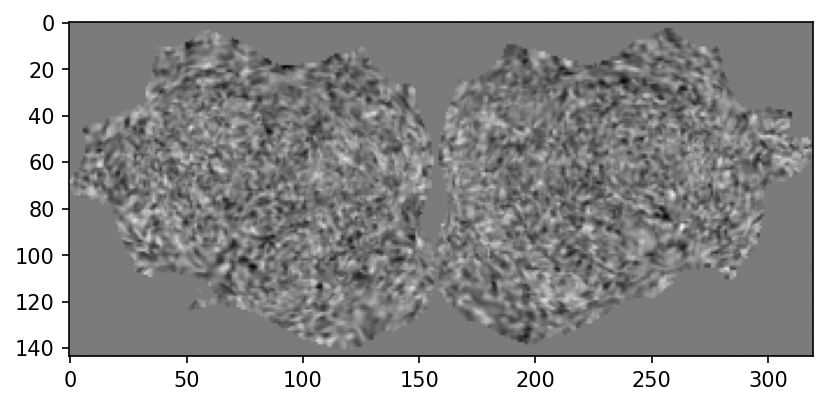

100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

input_func torch.Size([32, 1, 16, 144, 320])
Execution time: 6.074275493621826 seconds


In [3]:
if utils.is_interactive():    
    start_time = time.time() 
    num_iters = 10 # set maximum iterations the loop will go for
    
    if "BOTH" in datasets_to_include:
        nsd_data_iter = iter(nsd_dl)
        hcp_data_iter = iter(hcp_dl)
    else:
        data_iter = iter(train_dl)
    
    for i in tqdm(range(num_iters)):
        if "BOTH" in datasets_to_include:
            nsd_batch = next(nsd_data_iter)
            hcp_batch = next(hcp_data_iter)
            nsd_input = nsd_batch[0].view(-1, *nsd_batch[0].shape[2:])
            hcp_input = hcp_batch[0].view(-1, *hcp_batch[0].shape[2:])
            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = hcp_input.shape
            hcp_input_reshaped = hcp_input.view(len(hcp_input), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            hcp_input = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            input_func = torch.cat([hcp_input, nsd_input], dim=0)
        elif "HCP" in datasets_to_include:
            batch = next(data_iter)
            meta = batch[1]
            input_func = batch[0].view(-1, *batch[0].shape[2:])
            
            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = input_func.shape
            hcp_input_reshaped = input_func.view(len(input_func), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            input_func = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
        else:
            batch = next(data_iter)
            meta = batch[1]
            input_func = batch[0].view(-1, *batch[0].shape[2:])
            
        if len(input_func) != batch_size:
            raise ValueError(f"Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")

        if i==0:
            plt.imshow(input_func[0,0,0], cmap='gray')
            plt.show()
    
    print("input_func", input_func.shape)
    
    end_time = time.time()  
    execution_time = end_time - start_time  
    print(f"Execution time: {execution_time} seconds")

# Create model

In [4]:
assert model_size in {"huge", "large", "small"}, "undefined model_size"

if model_size=="huge":
    model = models.mae_vit_huge_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="large":
    model = models.mae_vit_large_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
elif model_size=="small":
    model = models.mae_vit_small_fmri(
        patch_size=patch_size,
        decoder_embed_dim=decoder_embed_dim,
        t_patch_size=t_patch_size,
        pred_t_dim=pred_t_dim,
        decoder_depth=4,
        cls_embed=cls_embed,
        decoder_cls_embed=decoder_cls_embed,
        norm_pix_loss=norm_pix_loss,
        no_qkv_bias=no_qkv_bias,
        sep_pos_embed=sep_pos_embed,
        trunc_init=trunc_init,
        pct_masks_to_decode=pct_masks_to_decode,
        img_mask=flat_mask,
        nsd_mask=nsd_mask,
        hcp_mask=hcp_mask,
        use_source_embeds=use_source_embeds,
        use_contrastive_loss=use_contrastive_loss,
        use_decoder_contrastive_loss=use_decoder_contrastive_loss,
        source_embed_train_mode=source_embed_train_mode,
        source_embed_mode=source_embed_mode,
    )
if use_contrastive_loss:
    model.simclr_handler = SimCLRHandler(model.embed_dim).to(device)
if use_decoder_contrastive_loss:
    model.decoder_simclr_handler = SimCLRHandler(model.decoder_embed_dim).to(device)
utils.count_params(model)

img_size (144, 320) patch_size (16, 16) frames 16 t_patch_size 2
model initialized
param counts:
316,392,704 total
316,392,704 trainable


316392704

# Set up optimizer and saving functions

In [ ]:
# TODO: FSDP not working if not using full node

print(f"\nChecking distributed setup on global_rank {global_rank}...")
if distributed:
    my_auto_wrap_policy = functools.partial(size_based_auto_wrap_policy, min_num_params=100000)
    print(f"\nPrepping FSDP on {global_rank} {node}...\n")
    model = model.to(device)
    model = FSDP(
        model,
        sharding_strategy=ShardingStrategy.NO_SHARD, # ShardingStrategy._HYBRID_SHARD_ZERO2, # ShardingStrategy.FULL_SHARD, ShardingStrategy._HYBRID_SHARD_ZERO2
        auto_wrap_policy=my_auto_wrap_policy,
        use_orig_params=False, 
        cpu_offload=None, #CPUOffload(offload_params=True), 
        sync_module_states=True,  
        limit_all_gathers=True,  # See https://github.com/pytorch/pytorch/issues/91165
        device_id=device,
        mixed_precision=MixedPrecision(param_dtype=torch.float32, reduce_dtype=torch.float32, buffer_dtype=torch.float32),
    )
    print(f"\nSuccessfully loaded FSDP model to device on global_rank {global_rank}\n")
    dist.barrier()
else:
    print(f"\nNot training distributed! global_rank {global_rank}")
    model.to(device)


Checking distributed setup on global_rank 0...

Not training distributed! global_rank 0


In [6]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
opt_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.05},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
]

lr = base_lr * global_batch_size / 256
print(f"multiply base lr {base_lr} by effective batch size {global_batch_size}")
print(f"lr = {lr}")

optimizer = torch.optim.AdamW(opt_grouped_parameters, lr=lr, betas=(0.9, 0.95))

def adjust_learning_rate(optimizer, epoch, warmup_epochs=5, min_lr=0.0):
    """Decay the learning rate with half-cycle cosine after warmup"""
    if epoch < warmup_epochs:
        lr_ = lr * epoch / warmup_epochs
    else:
        lr_ = min_lr + (lr - min_lr) * 0.5 * (
            1.0
            + math.cos(
                math.pi
                * (epoch - warmup_epochs)
                / (num_epochs - warmup_epochs)
            )
        )
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_
    return lr_

print("\nDone with model preparations!")
num_params = utils.count_params(model)

multiply base lr 0.001 by effective batch size 32
lr = 0.000125

Done with model preparations!
param counts:
316,392,704 total
316,392,704 trainable


In [7]:
def save_ckpt(model, global_rank=0, tag="last"):
    if distributed: 
        dist.barrier()
        with FSDP.state_dict_type(model, StateDictType.FULL_STATE_DICT):
            model_states = model.state_dict() 
            optimizer_states = optimizer.state_dict()
    else:
        model_states = model.state_dict() # now collecting the full state dict
        optimizer_states = optimizer.state_dict() # optimizer also needs the full state
    if global_rank == 0: 
        os.makedirs(outdir, exist_ok=True)
        ckpt_path = outdir + f'/{tag}.pth'
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_states,
            'optimizer_state_dict': optimizer_states,
        }, ckpt_path)
        print(f"\n---saved {ckpt_path}!---\n")

        if not os.path.exists(f"{outdir}/config.yaml"):
            with open(f"{outdir}/config.yaml", 'w') as file:
                yaml.dump(config, file)
            print(f"saved {outdir}/config.yaml!")
    if distributed:
        print(f"global_rank{global_rank} hit barrier...")
        dist.barrier()

# Load checkpoint

In [8]:
epoch = 0
outdir_to_load = outdir
if resume_from_ckpt and local_rank==0:
    if not os.path.exists(outdir_to_load) or not os.path.isdir(outdir_to_load):
        print(f"\nNot resuming from ckpt. Checkpoint folder {outdir_to_load} does not exist.\n")
    else:
        checkpoint_files = [f for f in os.listdir(outdir_to_load) if f.endswith('.pth')]

        # Extract epoch numbers and find the largest
        epoch_numbers = []
        for file in checkpoint_files:
            try:
                epoch_number = int(file.split('epoch')[-1].split('.')[0])
                epoch_numbers.append(epoch_number)
            except ValueError:
                continue

        latest_epoch = max(epoch_numbers)
        latest_checkpoint = f"epoch{latest_epoch}.pth"

        # Load the checkpoint
        checkpoint_path = os.path.join(outdir_to_load, latest_checkpoint)

        state = torch.load(checkpoint_path)
        if distributed:
            with FSDP.state_dict_type(model, StateDictType.FULL_STATE_DICT):
                model.load_state_dict(state["model_state_dict"], strict=True)
        else:
            model.load_state_dict(state["model_state_dict"], strict=True)
        
        # Optimizer loading
        saved_state_dict = state['optimizer_state_dict']
        # adjust the saved state dict to match the current optimizer's structure
        for i, group in enumerate(optimizer.param_groups):
            # Ensure the params in the saved state match the current optimizer's params
            saved_state_dict['param_groups'][i]['params'] = group['params']
        optimizer.load_state_dict(saved_state_dict)

        print(f"\nLoaded checkpoint {latest_checkpoint} from {outdir_to_load}. Epoch = {epoch}\n")


Not resuming from ckpt. Checkpoint folder /home/connor/fmri-fm/checkpoints/HCP_large_pt1_91601 does not exist.



# Start wandb (if enabled)

In [9]:
if utils.is_interactive():
    print("Running inside interactive notebook. Disabling wandb and ckpt saving...")
    wandb_log = False
    ckpt_saving = False
if global_rank==0 and wandb_log: # only use main process for wandb logging
    import wandb
    wandb_project = 'fMRI-foundation-model'
    print(f"wandb {wandb_project} run {model_name}")
    # need to configure wandb beforehand in terminal with "wandb init"!
    wandb_config = {
      "model_name": model_name,
      "global_batch_size": global_batch_size,
      "batch_size": batch_size,
      "num_epochs": num_epochs,
      "cls_embed": cls_embed,
      "norm_pix_loss": norm_pix_loss,
      "patch_size": patch_size,
      "t_patch_size": t_patch_size,
      "pred_t_dim": pred_t_dim,
      "mask_ratio": mask_ratio,
      "num_frames": num_frames,
      "sep_pos_embed": sep_pos_embed,
      "decoder_embed_dim": decoder_embed_dim,
      "use_contrastive_loss": use_contrastive_loss,
      "num_params": num_params,
      "num_sessions": num_sessions,
      "base_lr": base_lr,
      "lr": lr,
      "num_samples_per_epoch": num_samples_per_epoch,
      "grad_clip": grad_clip,
      "ckpt_interval": ckpt_interval,
      "ckpt_saving": ckpt_saving,
      "print_interval": print_interval,
      "seed": seed,
      "distributed": distributed,
      "grad_accumulation_steps": grad_accumulation_steps,
      "world_size": world_size,
    }
    print("wandb_config:\n",wandb_config)
    print("wandb_id:",model_name)
    wandb.init(
        id=model_name,
        project=wandb_project,
        entity=wandb_entity,
        name=model_name,
        config=wandb_config,
        resume="allow",
        save_code=True,
    )
    
    # Reprint the config so that wandb captures it in the output log
    print("\n__CONFIG__")
    for attribute_name in config.keys():
        if global_rank==0:
            print(f"{attribute_name} = {config[attribute_name]}")
        globals()[attribute_name] = config[f'{attribute_name}']
    print("\n")
else:
    wandb_log = False

Running inside interactive notebook. Disabling wandb and ckpt saving...


# Start training

In [10]:
start_time = time.time()
first_log = get_system_metrics(start_time)
print(f"global_rank:{global_rank} | local_rank:{local_rank} | {first_log}")

global_rank:0 | local_rank:0 | {'utils/timestamp': 1748979447.346054, 'utils/rel_timestamp': 1.7881393432617188e-05, 'utils/cpu_util': 2.0, 'utils/ram_percent': 1.2, 'utils/swap_percent': 0.0, 'utils/cpu_rss_mb': 1510.3671875, 'utils/gpu_0_util': 0.0, 'utils/gpu_0_mem_percent': 0.0, 'utils/gpu_0_temp': 31.0, 'utils/gpu_1_util': 0.0, 'utils/gpu_1_mem_percent': 0.0, 'utils/gpu_1_temp': 28.0, 'utils/gpu_2_util': 0.0, 'utils/gpu_2_mem_percent': 0.0, 'utils/gpu_2_temp': 29.0, 'utils/gpu_3_util': 0.0, 'utils/gpu_3_mem_percent': 0.0, 'utils/gpu_3_temp': 28.0, 'utils/gpu_4_util': 0.0, 'utils/gpu_4_mem_percent': 0.0, 'utils/gpu_4_temp': 30.0, 'utils/gpu_5_util': 0.0, 'utils/gpu_5_mem_percent': 0.0, 'utils/gpu_5_temp': 27.0, 'utils/gpu_6_util': 0.0, 'utils/gpu_6_mem_percent': 0.0, 'utils/gpu_6_temp': 28.0, 'utils/gpu_7_util': 0.0, 'utils/gpu_7_mem_percent': 0.0, 'utils/gpu_7_temp': 27.0}


In [11]:
grad_scaler = torch.GradScaler(enabled=True)
if distributed: dist.barrier()
for epoch in tqdm(range(epoch, num_epochs)):
    lrs, train_losses, test_losses = [], [], []
    recon_losses1, source_losses1, recon_losses2, source_losses2 = [], [], [], []
    encoder_cont_losses, decoder_cont_losses = [], []
    
    model.train()
    if "BOTH" in datasets_to_include:
        nsd_data_iter = iter(nsd_dl)
        hcp_data_iter = iter(hcp_dl)
    else:
        data_iter = iter(train_dl)
    
    for train_i in range(num_batches):
        if "BOTH" in datasets_to_include:
            nsd_batch = next(nsd_data_iter)
            hcp_batch = next(hcp_data_iter)
            nsd_input = nsd_batch[0].view(-1, *nsd_batch[0].shape[2:])
            hcp_input = hcp_batch[0].view(-1, *hcp_batch[0].shape[2:])
            # average pooling across consecutive frames to have approx similar TR across datasets
            hcp_shape = hcp_input.shape
            hcp_input_reshaped = hcp_input.view(len(hcp_input), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
            hcp_input = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            input_func = torch.cat([hcp_input, nsd_input], dim=0).to(device=device, non_blocking=True)
                
            if use_source_embeds:
                hcp_source_ids = torch.LongTensor([1 if np.array(meta)=='3T' else 2 for meta in hcp_batch[1]["mag"]])
                nsd_source_ids = torch.LongTensor([0 for _ in range(len(nsd_batch[0]))])
                source_ids = torch.cat([hcp_source_ids, nsd_source_ids], dim=0).to(device=device, non_blocking=True)
            else:
                source_ids = None
        else:
            batch = next(data_iter)
            input_func = batch[0].view(-1, *batch[0].shape[2:]).to(device=device, non_blocking=True)
            
            if len(input_func) != batch_size:
                raise ValueError(f"Error! Input length ({len(input_func)}) does not match the expected batch size ({batch_size}).")

            if "HCP" in datasets_to_include:
                # average pooling across consecutive frames to have approx similar TR across datasets
                hcp_shape = input_func.shape
                hcp_input_reshaped = input_func.view(len(input_func), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
                input_func = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            
            if use_source_embeds:
                if "HCP" in datasets_to_include:
                    source_ids = torch.LongTensor([1 if np.array(meta)=='3T' else 2 for meta in batch[1]["mag"]])
                else:
                    source_ids = torch.LongTensor([0 for _ in range(len(batch[0]))])
                source_ids = source_ids.to(device=device, non_blocking=True)
            else:
                source_ids = None

        adjust_learning_rate(optimizer, train_i / num_batches + epoch)

        if not use_contrastive_loss:
            loss, source_loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss, source_ids=source_ids)
            loss = loss + source_loss
        else:
            recon_loss1, source_loss1, recon_loss2, source_loss2, encoder_cont_loss, decoder_cont_loss, pred1, pred2, mask1, mask2, true_mask, latent1, latent2 = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss, source_ids=source_ids, distributed=distributed)
            pred, mask = pred1, mask1

            loss = recon_loss1 + source_loss1 + recon_loss2 + source_loss2 + encoder_cont_loss + decoder_cont_loss
            
            recon_losses1.append(recon_loss1.item())
            source_losses1.append(source_loss1.item())
            recon_losses2.append(recon_loss2.item())
            source_losses2.append(source_loss2.item())
            encoder_cont_losses.append(encoder_cont_loss.item())
            decoder_cont_losses.append(decoder_cont_loss.item())

        loss = loss / grad_accumulation_steps # normalize the loss by grad accumulation steps
        grad_scaler.scale(loss).backward()
        
        if (train_i + 1) % grad_accumulation_steps == 0:
            grad_scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            grad_scaler.step(optimizer)
            grad_scaler.update()
            optimizer.zero_grad(set_to_none=True)
            torch.cuda.synchronize()

        lrs.append(optimizer.param_groups[0]["lr"])
        train_losses.append(loss.item() * grad_accumulation_steps)
        
        if (train_i%print_interval)==0:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {lrs[-1]} | {train_i}/{num_batches} | {datetime.now().strftime('%H:%M:%S %Y-%m-%d')}")
        
        if wandb_log: 
            if not use_contrastive_loss:
                logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                        "train/lr": lrs[-1]}
            else:
                logs = {"train/loss": np.mean(train_losses[-print_interval:]),
                        "train/lr": lrs[-1],
                        "train/recon_loss": np.mean(recon_losses1[-print_interval:] + recon_losses2[-print_interval:])/2,
                        "train/source_loss": np.mean(source_losses1[-print_interval:] + source_losses2[-print_interval:])/2,
                        "train/cont_loss": np.mean(encoder_cont_losses[-print_interval:]),
                       }
                if use_decoder_contrastive_loss:
                    logs["train/decoder_cont_loss"] = np.mean(decoder_cont_losses[-print_interval:])
            system_logs = get_system_metrics(start_time)
            logs.update(system_logs)
            # epoch_1000x as x-axis calibrates different curves when batch size changes
            epoch_1000x = int((train_i / num_batches + epoch) * 1000)
            wandb.log(logs, step=epoch_1000x)

        del loss, pred, mask, latent, input_func 
                
    print(f"\nPassed training epoch {epoch}")

    # TEST SET #
    with torch.no_grad():
        for test_i in range(num_test_batches):
            batch = next(iter(test_dl))
            input_func = batch[0].view(-1, *batch[0].shape[2:]).to(device=device, non_blocking=True)

            if "HCP" in datasets_to_include:
                # average pooling across consecutive frames to have approx similar TR across datasets
                hcp_shape = input_func.shape
                hcp_input_reshaped = input_func.view(len(input_func), 2, hcp_shape[2]//2, hcp_shape[3], hcp_shape[4])
                input_func = hcp_input_reshaped.mean(dim=1).unsqueeze(1) 
            
            if len(input_func) != batch_size:
                raise ValueError(f"Error! Input length ({len(input_func)}) does not match the expected batch_size ({batch_size}).")
        
            if use_source_embeds:
                if "HCP" in datasets_to_include:
                    source_ids = torch.LongTensor([1 if np.array(meta)=='3T' else 2 for meta in batch[1]["mag"]])
                else:
                    source_ids = torch.LongTensor([0 for _ in range(len(batch[0]))])
                source_ids = source_ids.to(device=device, non_blocking=True)
            else:
                source_ids = None
        
            loss, source_loss, pred, mask, latent = model(input_func, mask_ratio=mask_ratio, use_contrastive_loss=use_contrastive_loss, source_ids=source_ids, deterministic=True)    
            test_losses.append(loss.item())

        print(f"\nPassed test eval | loss {np.mean(test_losses[-num_test_batches:])}")
            
        if wandb_log: 
            logs = {"test/loss": np.mean(test_losses[-num_test_batches:])}
            wandb.log(logs, step=epoch_1000x)
                    
        if utils.is_interactive() or wandb_log:
            print(f"Ep. {epoch} | loss {np.mean(train_losses[-print_interval:]):.3f} | lr {optimizer.param_groups[0]['lr']} | {train_i}/{num_batches}")
            if plotting:
                with torch.no_grad():
                    print("\n Test plotting...")
                    if norm_pix_loss:
                        normed_input_func, patch_info = model.patchify(input_func, alter_patch_info=False, return_patch_info=True)
                        target_mean = normed_input_func.mean(dim=-1, keepdim=True)
                        target_var = normed_input_func.var(dim=-1, keepdim=True)
                        normed_input_func = (normed_input_func - target_mean) / (target_var + 1.0e-6) ** 0.5
                        normed_input_func = model.unpatchify(normed_input_func, patch_info=patch_info)
        
                        vis_out = vis.plot_mask_pred(
                            model, normed_input_func, pred, mask, 
                            mean=0.5, std=0.2, 
                        )
                    else:
                        vis_out = vis.plot_mask_pred(
                            model, input_func, pred, mask, 
                            mean=0.5, std=0.2, 
                        )
        
                    if wandb_log:
                        logs = {"test/mask_pred": wandb.Image(vis_out)}
                        wandb.log(logs, step=epoch_1000x)
                    else:
                        display(vis_out)
    
                    plt.close()
    
        # Save model checkpoint
        if (ckpt_saving and epoch>0) and ((epoch % ckpt_interval == 0) or (epoch==num_epochs-1)):
            save_ckpt(model,global_rank=global_rank,tag=f"epoch{epoch}") # save_ckpt() already performs dist.barrier
        elif distributed: 
            print(f"global_rank{global_rank} hit barrier...")
            dist.barrier()
        torch.cuda.empty_cache()

# final check of system utilization
system_logs = get_system_metrics(start_time)
print(f"global_rank:{global_rank} | local_rank:{local_rank} | {system_logs}")
if wandb_log: wandb.log(system_logs, step=epoch_1000x+1)

# clean up and quit 
if distributed: dist.destroy_process_group()
print("\n===FINISHED===")
print(f"Total training time: {timedelta(seconds=system_logs['utils/timestamp'] - first_log['utils/timestamp'])}")
if not utils.is_interactive(): exit

  0%|          | 0/100 [00:00<?, ?it/s]

Ep. 0 | loss 1.767 | lr 0.0 | 0/6250 | 19:37:29 2025-06-03
Ep. 0 | loss 1.701 | lr 8e-08 | 20/6250 | 19:37:40 2025-06-03


  0%|          | 0/100 [00:15<?, ?it/s]


KeyboardInterrupt: 